# Introduction


## Dataset

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.


## Content

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.   

Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.   

The training and test data sets have 785 columns.   

The first column consists of the class labels (see above), and represents the article of clothing. 

The rest of 784 columns (1-785) contain the pixel-values of the associated image.

# Load packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras

from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.python.keras. preprocessing.image import ImageDataGenerator
from IPython.display import SVG
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Using TensorFlow backend.


## Parameters

In [2]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2018
#Model
NO_EPOCHS = 50
BATCH_SIZE = 128

IS_LOCAL = True



# Utilities

Functions, kindly provided by people from Kaggle, to allow some easier description of models and plotting.

In [3]:

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))
        
def sample_images_data(data):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in labels.keys():
        # Get four samples for each category
        samples = data[data["label"] == k].head(4)
        # Append the samples to the samples list
        for j, s in enumerate(samples.values):
            # First column contain labels, hence index should start from 1
            img = np.array(samples.iloc[j, 1:]).reshape(IMG_ROWS,IMG_COLS)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(15,15))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(X_test[indx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[y_true[indx]],labels[predicted_classes[indx]]))
    plt.show()    
    

def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()    
    

def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')

# Read the data

There are 10 different classes of images, as following: 

* **0**: **T-shirt/top**;   
* **1**: **Trouser**;   
* **2**: **Pullover**;   
* **3**: **Dress**;
* **4**: **Coat**;
* **5**: **Sandal**;
* **6**: **Shirt**;
* **7**: **Sneaker**;
* **8**: **Bag**;
* **9**: **Ankle boot**.

Image dimmensions are **28**x**28**.   

The train set and test set are given in two separate datasets.


In [4]:
import os

if(IS_LOCAL):
    PATH="/input/"
    train_file = PATH+"fashion-mnist_train.csv"
    test_file  = PATH+"fashion-mnist_test.csv"

    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
else:
    ((X, y), (X_test, y_test)) = fashion_mnist.load_data()
print(os.listdir(PATH))


['t10k-images-idx3-ubyte', 'train-labels-idx1-ubyte', 'fashion-mnist_train.csv', 'train-images-idx3-ubyte', 't10k-labels-idx1-ubyte', 'fashion-mnist_test.csv']


# Data analysis

## Class distribution

Let's see how many number of images are in each class. It's good to know this because an imbalanced dataset could lead to some trouble, and this should be known before designing the model.

In [5]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}


get_classes_distribution(train_data)

Ankle Boot          :   6000 or 10.0%
Bag                 :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Coat                :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Trouser             :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%


## Sample images

Let's plot some samples for the images to get a feeling of what the data looks like.  
We add labels to the train set images, with the corresponding fashion item category.  

Total number of sample images to plot:  40


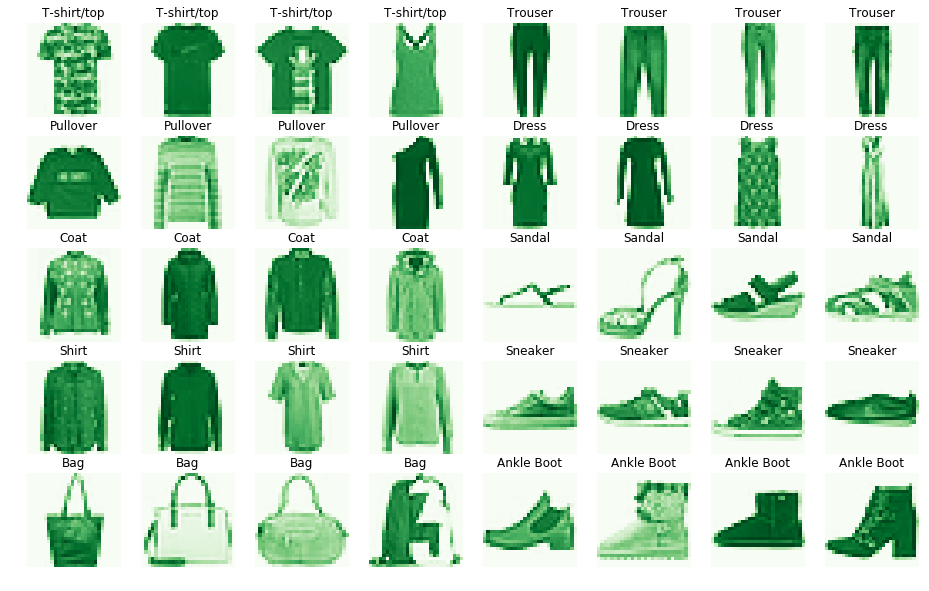

In [6]:
train_sample_images, train_sample_labels = sample_images_data(train_data)
plot_sample_images(train_sample_images,train_sample_labels, "Greens")

# Model

## Data preprocessing

First we will do a data preprocessing to prepare for the model.

We reshape the columns from (784) to (28,28,1). We also save label (target) feature as a separate vector.

In [7]:
# data preprocessing
def data_preprocessing(raw):
    out_y = keras.utils.to_categorical(raw.label, NUM_CLASSES)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

We process both the train_data and the test_data

In [8]:
# prepare the data
# This is only needed if we are using local data
if(IS_LOCAL):
    X, y = data_preprocessing(train_data)
    X_test, y_test = data_preprocessing(test_data)

## Split data in train and validation set

We further split the train set in train and validation set. A good rule of thumb is to take 20% of the data for the validation set.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

Now let's see the final shape of the processed data for training, validation and testing.

In [10]:
print("Fashion MNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


## Train the model

### Build the model   


The initial model will be a simple model good enough for small image recognition as it is needed. 
It will be constructed from three 3x3x1 convolutional layers, with MaxPooling layers in between, and a fully connected layer at the end.

In [11]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_uniform',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer = 'he_uniform'))
model.add(Dense(NUM_CLASSES, activation='softmax'))


n_opt = optimizers.SGD( momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=n_opt,
              metrics=['accuracy'])

### Inspect the model

We can get a summary and a plot of the model that was created.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
__________

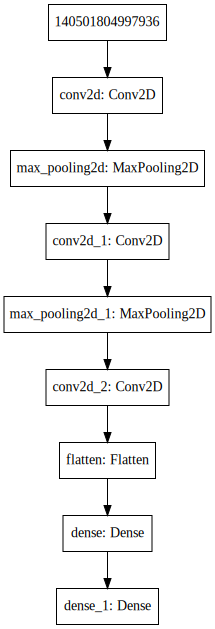

In [ ]:
model.summary()

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train the model

Now we can train the model with the already setup datasets for training and validation. The test set will be used later on during evaluation.

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 9s 180us/step - loss: 0.6373 - acc: 0.7633 - val_loss: 0.4901 - val_acc: 0.8094
Epoch 2/50
48000/48000 [==============================] - 2s 40us/step - loss: 0.4022 - acc: 0.8545 - val_loss: 0.3852 - val_acc: 0.8625
Epoch 3/50
48000/48000 [==============================] - 2s 41us/step - loss: 0.3453 - acc: 0.8744 - val_loss: 0.3750 - val_acc: 0.8627
Epoch 4/50
48000/48000 [==============================] - 2s 40us/step - loss: 0.3124 - acc: 0.8865 - val_loss: 0.3229 - val_acc: 0.8850
Epoch 5/50
48000/48000 [==============================] - 2s 46us/step - loss: 0.2882 - acc: 0.8961 - val_loss: 0.3051 - val_acc: 0.8947
Epoch 6/50
48000/48000 [==============================] - 2s 40us/step - loss: 0.2679 - acc: 0.9018 - val_loss: 0.3135 - val_acc: 0.8876
Epoch 7/50
48000/48000 [==============================] - 2s 40us/step - loss: 0.2502 - acc: 0.9093 - val_loss: 0.2897 - val_ac

## Test prediction accuracy

After the model has been trained, we can evaluate it.Chosen type of evaluation for the process is accuracy.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test accuracy is  around  0.91.

We evaluated the model accuracy based on the predicted values for the test set.  Let's check the validation value during training.



## Validation accuracy and loss

Let's plot the train and validation accuracy and loss, from the train history.

In [ ]:
plot_accuracy_and_loss(train_model)

The validation accuracy does not improve after few epochs and the validation loss is increasing after few epochs. This confirms our assumption that the model is overfitted. We will try to improve the model by adding Dropout layers.

## Add Dropout layers to the model

We add several Dropout layers to the model, to help avoiding overfitting.    
Dropout is helping avoid overfitting in several ways, as explained in <a href='#refs'>[6]</a> and <a href='#refs'>[7]</a>.  
Smaller dropout for Convolutional layers as suggested in:<a href='#refs'>[8]</a> 

In [ ]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))

n_opt = optimizers.SGD( momentum=0.9, nesterov=True)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=n_opt,
              metrics=['accuracy'])

## Model with dropout summary

Let's inspect first the model.

In [ ]:
model.summary()

plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Again let's run the new model.

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))              

## Model with added droupout evaluation

After adding the Dropout layers, the validation accuracy and validation loss are much better. Let's check now the prediction for the test set.

Let's re-evaluate the test prediction accuracy with the new model.

In [ ]:
plot_accuracy_and_loss(train_model)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Also the test accuracy improved. The test accuracy is now approximately 0.92.

# Further model optimizations

We can try to build on this furhter. 

Even though  Adam optimization can cause problems <a href='#refs'>[9]</a> It might prove ok for our application. 

After each convolutional layer Batch normalization can be added. <a href='#refs'>[10]</a> <a href='#refs'>[11]</a>

ELU as an activation function instead of ReLU could bring an improvement as well. This will slightly slow down training, but the model will be faster to converge.

In [ ]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='elu',
                 kernel_initializer='he_uniform',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='elu'))
model.add(BatchNormalization())

# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

## Checkpoints

Let's add checkpoint saving as well. This will save the weights of the model which had the smallest validation loss, and should save the weights before the model starts overfitting.

In [ ]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val), callbacks = callbacks_list)

Reload the best weights and recompile the model (needed in order to make predictions).

In [ ]:
model.load_weights("weights.best.hdf5")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
plot_accuracy_and_loss(train_model)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Data augmentation

Finally we can try to add some data augmentation on the model. The data is safe to augment with horizontal flips.

In [ ]:
image_aug = ImageDataGenerator(horizontal_flip = True)
image_aug.fit(X_train)

Let's recompile the previous model and retrain it with augmented data.

In [ ]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='elu',
                 kernel_initializer='he_uniform',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='elu'))
model.add(BatchNormalization())

# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
train_model = model.fit_generator(image_aug.flow(X_train, y_train, batch_size = BATCH_SIZE),
                  steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val), callbacks= callbacks_list)


In [ ]:
plot_accuracy_and_loss(train_model)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Predictions of the trained model

We can further test some metrics of the model when faced with predictions such as precision, recall, and the F1 score.

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)
#get the indices to be plotted
y_true = test_data.iloc[:, 0]

In [ ]:
p = predicted_classes[:10000]
y = y_true[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

In [ ]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

In [ ]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

# Visualize classified images

## Correctly classified images


Finnally, let's visualize a few images to get a feeling at what the model does good and where it makes mistakes.

In [ ]:
plot_images(correct, "Greens")

## Incorrectly classified images

Let's see also few images incorrectly classified.

In [ ]:
plot_images(incorrect, "Reds")

# Conclusions

With a complex sequential model with multiple convolution layers and 50 epochs for the training, we obtained an accuracy ~0.91 for test prediction.

However, on such a small dataset, a model like this is very prone to overfitting. An analysis of the validation accuracy and loss showed that this was true.

Adding the dropout layers provided enough of regularization to prevent overfitting. This method slowed down training time, but it does not affect time needed for predictions, since the dropout layers are only used during training. Since this method provided an acuraccy of 92% it is a fairly good approach for some general applications.

Further optimizations can be done by adding Batch Normalization, changing the activation functions, using checkpoints and early stopping, but this all comes at a cost of longer training time, more parameters to train (which means more memory consumption), and more time needed for predictions.

Finally, a good approach would be to add data augmentation to this set, such as horizontal flipping. Since data augmentation is done as a preprocessing step, this does not affect the performance time of neither training nor predictions, and can further increase accuracy.

# <a id='refs'> References </a>

[1] Fashion MNIST, An MNIST-like dataset of 70,000 28x28 labeled fashion images, https://www.kaggle.com/zalando-research/fashionmnist  
[2] DanB, CollinMoris, Deep Learning From Scratch, https://www.kaggle.com/dansbecker/deep-learning-from-scratch  
[3] DanB, Dropout and Strides for Larger Models, https://www.kaggle.com/dansbecker/dropout-and-strides-for-larger-models  
[4] BGO, CNN with Keras, https://www.kaggle.com/bugraokcu/cnn-with-keras    
[5] NAIN, EagerFMINST, https://www.kaggle.com/aakashnain/eagerfmnist  
[6] Why Dropounts prevent overfitting in Deep Neural Networks, https://medium.com/@vivek.yadav/why-dropouts-prevent-overfitting-in-deep-neural-networks-937e2543a701  
[7] Dropout: A Simple Way to Prevent Neural Networks from Overfitting, https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf  
[8] Vu Pham et al, Dropout improves Recurrent Neural Networks for Handwriting Recognition, https://arxiv.org/pdf/1312.4569.pdf
[9] Ashia C. Wilson et al, The Marginal Value of Adaptive Gradient Methods in Machine Learning, https://arxiv.org/pdf/1705.08292.pdf 
[10] batch normalization, https://standardfrancis.wordpress.com/2015/04/16/batch-normalization/
[11] Sergey Ioffe, Christian Szegedy, Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift, https://arxiv.org/abs/1502.03167
